In [1]:
import sys
import os

import librosa  # python package for music and audio analysis
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import noisereduce as no
import matplotlib.image as mpimg
import tensorflow as tf

from pprint import pprint 
import imutils
import cv2

/opt/anaconda3/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [4]:
fmin = 1400

# References:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# https://github.com/m-kortas/Sound-based-bird-species-detection/blob/master/MK_prepareData.ipynb
def get_melspectrogram_db(file_path, sec_limit=300):
    n_fft = 2048
    hop_length = 512   
    n_mels = 1024

    signal, sr = librosa.load(file_path)
    signal_limit = sr*sec_limit
    if signal.shape[0] > signal_limit:
        signal = signal[:signal_limit]
    
    signal = no.reduce_noise(audio_clip=signal, noise_clip=signal, verbose=False)

    spec = librosa.feature.melspectrogram(
        signal, 
        sr=sr, 
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin
    )
    
    return librosa.power_to_db(spec, ref=np.max)

In [5]:
# References:
# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    spec_scaled = np.flip(spec_scaled, axis=0)

    return spec_scaled

In [6]:
# Example
train.iloc[2]

rating                                                              4
playback_used                                                      no
ebird_code                                                     aldfly
channels                                                   2 (stereo)
date                                                       2013-05-27
pitch                                                            both
duration                                                           39
filename                                                 XC135455.mp3
speed                                                            both
species                                              Alder Flycatcher
number_of_notes                                                   1-3
title                   XC135455 Alder Flycatcher (Empidonax alnorum)
secondary_labels                                                   []
bird_seen                                                         yes
sci_name            

In [7]:
example_file = './data/train_audio/aldfly/XC135454.mp3'

In [8]:
mel = get_melspectrogram_db(example_file)
img = spec_to_image(mel)

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


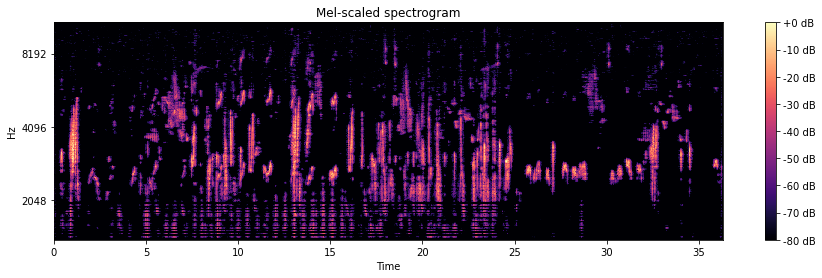

In [9]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mel, fmin=fmin, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

In [10]:
def resize_img(img, size=512):    
    height, width = img.shape
    width = width*2
    padding = int(np.floor(np.abs(
        (width-height)/2
    )))
    dimension = width if width > height else height 
    
    img = cv2.resize(img, (width, height))
    img_padded = np.zeros((dimension, dimension))
    
    if height < width:
        img_padded[padding:(padding + height), :width] = img
    else: 
        img_padded[:height, padding:(padding + width)] = img

    return imutils.resize(img_padded, width=size)

In [11]:
img_resized = resize_img(img)

In [12]:
img_resized.shape

(512, 512)

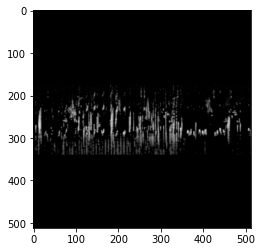

In [13]:
plt.imshow(img_resized, cmap='gray')

In [14]:
mpimg.imsave("example.png", img_resized, cmap='gray')

In [15]:
working_dir = "./data/train_audio/"
birds = []
flist = {} 

for root, dirs, files in os.walk(working_dir):
    if root == working_dir:
        birds = dirs

for i, bird in enumerate(birds):
    blist = [] 
    
    for root, dirs, files in os.walk(working_dir + bird):
        for file in files:
            if file.endswith(".mp3"):
                blist.append(os.path.join(root, file))

    flist[bird] = blist

In [16]:
storage_dir = "./data/train_img/"
existing_birds = []
existing_flist = {}

for root, dirs, files in os.walk(storage_dir):
    if root == storage_dir:
        existing_birds = dirs

for i, bird in enumerate(existing_birds):
    blist = [] 
    
    for root, dirs, files in os.walk(storage_dir + bird):
        for file in files:
            if file.endswith(".png"):
                blist.append(file)

    existing_flist[bird] = blist

In [ ]:
import warnings
warnings.filterwarnings('ignore')

birds_handled = 0

for bird, files in flist.items():
    bird_dir = storage_dir + bird
    
    if not os.path.exists(bird_dir):
        os.mkdir(bird_dir)
    
    birds_handled += 1
    print(birds_handled)
    
    for file in files:
        if file.endswith(".mp3"):
            name = file.split('/')[-1].split('.')[0] + '.png'
                    
            if bird in existing_birds and name in existing_flist[bird]:
                continue

            img = spec_to_image(get_melspectrogram_db(file))
            img = resize_img(img)
            mpimg.imsave(storage_dir + bird + "/" + name, img, cmap='gray')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
